In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
!pip install lightning
from lightning import LightningModule, LightningDataModule, Trainer, Callback
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from IPython.display import display, clear_output
from google.colab import drive
drive.mount("/content/drive")

In [2]:
class LeNet(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        predicts = torch.argmax(logits, dim=1)
        accuracy = accuracy_score(y.cpu().numpy(), predicts.cpu().numpy())
        values = {"train_loss": loss, "train_accuracy": torch.tensor(accuracy)}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        predicts = torch.argmax(logits, dim=1)
        accuracy = accuracy_score(y.cpu().numpy(), predicts.cpu().numpy())
        values = {"val_loss": loss, "val_accuracy": torch.tensor(accuracy)}
        self.log_dict(values, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.007)


model = LeNet()

In [3]:
class MNIST(LightningDataModule):
    def __init__(self, batch_size=100):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

    def prepare_data(self):
        datasets.MNIST(root=".", train=True, download=True)

    def setup(self, stage=None):
        if stage in ("fit", None):
            mnist_full = datasets.MNIST(root=".", train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000])

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)


data = MNIST()

In [4]:
class MetricsPlotter(Callback):
    def __init__(self, max_epochs=13):
        super().__init__()
        self.max_epochs = max_epochs
        self.metrics = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
        }

    def on_validation_epoch_end(self, trainer, pl_module):
        self.update_metrics(trainer)

    def on_train_epoch_end(self, trainer, pl_module):
        self.update_metrics(trainer)

    def update_metrics(self, trainer):
        for key in self.metrics.keys():
            val = trainer.logged_metrics.get(key, 0)
            if isinstance(val, torch.Tensor):
                val = val.cpu().numpy()
            self.metrics[key].append(val)

        clear_output(wait=True)
        self.plot_metrics()

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(
            self.metrics["train_loss"],
            label=f"Training Loss: {self.metrics['train_loss'][-1]:.2f}",
        )
        plt.plot(
            self.metrics["val_loss"],
            label=f"Validation Loss: {self.metrics['val_loss'][-1]:.2f}",
        )
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        if self.max_epochs:
            plt.xlim([0, self.max_epochs])

        plt.subplot(1, 2, 2)
        plt.plot(
            self.metrics["train_accuracy"],
            label=f"Training Accuracy: {self.metrics['train_accuracy'][-1]:.2f}",
        )
        plt.plot(
            self.metrics["val_accuracy"],
            label=f"Validation Accuracy: {self.metrics['val_accuracy'][-1]:.2f}",
        )
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        if self.max_epochs:
            plt.xlim([0, self.max_epochs])

        display(plt.gcf())
        plt.close()

In [ ]:
trainer = Trainer(
    callbacks=[MetricsPlotter()],
    max_epochs=13,
    default_root_dir="/content/drive/MyDrive/CNNs/Lightning/",
)

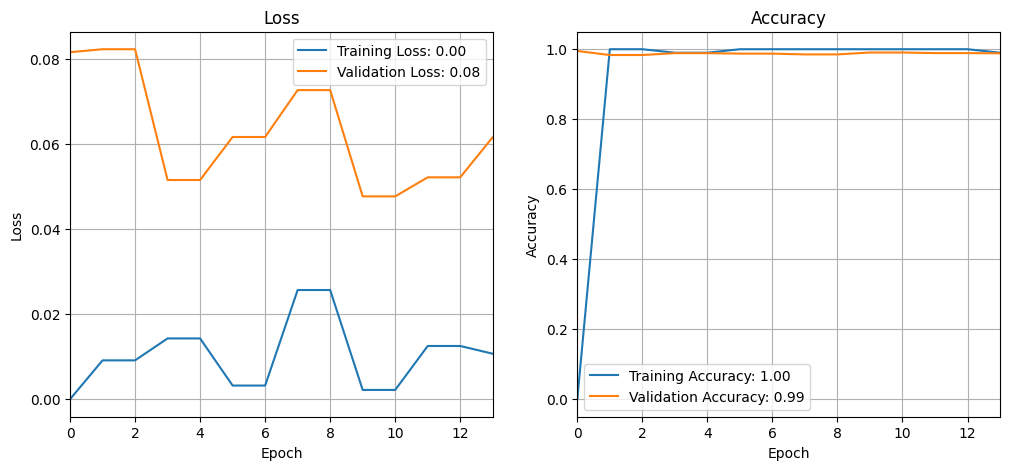

In [ ]:
trainer.fit(model, data, ckpt_path="last")